## Tacotron 2 inference code 

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('tacotron2/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
sys.path.append('tacotron2/waveglow/')
from denoiser import Denoiser

/home/dcalvo/miniconda3/envs/tacotron2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/dcalvo/miniconda3/envs/tacotron2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dcalvo/miniconda3/envs/tacotron2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dcalvo/miniconda3/envs/tacotron2/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <modul

In [2]:
def plot_data(data, figsize=(16, 4), label=""):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    plt.suptitle(label)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', interpolation='none')
    plt.show()

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.max_decoder_steps = 10000
hparams

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



HParams([('attention_dim', 128), ('attention_location_kernel_size', 31), ('attention_location_n_filters', 32), ('attention_rnn_dim', 1024), ('batch_size', 48), ('cudnn_benchmark', False), ('cudnn_enabled', True), ('decoder_rnn_dim', 1024), ('dist_backend', 'nccl'), ('dist_url', 'tcp://localhost:54321'), ('distributed_run', False), ('dynamic_loss_scaling', True), ('encoder_embedding_dim', 512), ('encoder_kernel_size', 5), ('encoder_n_convolutions', 3), ('epochs', 5000), ('filter_length', 1024), ('fp16_run', True), ('gate_threshold', 0.5), ('grad_clip_thresh', 1.0), ('hop_length', 256), ('ignore_layers', ['']), ('iters_per_checkpoint', 500), ('learning_rate', 0.0001), ('load_mel_from_disk', False), ('mask_padding', True), ('max_decoder_steps', 10000), ('max_wav_value', 32768.0), ('mel_fmax', 8000.0), ('mel_fmin', 0.0), ('n_frames_per_step', 1), ('n_mel_channels', 80), ('n_symbols', 148), ('p_attention_dropout', 0.1), ('p_decoder_dropout', 0.1), ('postnet_embedding_dim', 512), ('postnet_k

#### Compare Different Checkpoints

In [4]:
lyre_dir = "./lyre"

# load waveglow
# waveglow_path = f"{lyre_dir}/waveglow_256channels_universal_v5.pt"
waveglow_path = f"{lyre_dir}/waveglow_checkpoints/waveglow_30000"
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

# checkpoints to test
hparams.max_decoder_steps = 3500 # max in 10GB of VRAM is 2500ish
checkpoint_dir = f"{lyre_dir}/tacotron_checkpoints/obama-full"
checkpoints = ["48000"]

model = load_model(hparams)

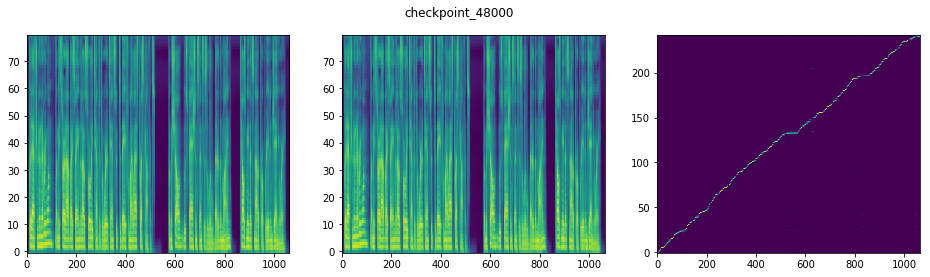

In [9]:
# text to speak
# text = """
# This is an example sentence of Barock Obama speaking. I am using it to demonstrate the difference between a universal and specific vocal synthesis model. This is the specific model.
# """
# text = """
# Yea I probably got a couple of screws up in my head loose
# But no worse than what's goin' on in your parents' bedrooms.
# Sometimes I wanna get on Tee Ve and just let loose,
# But can't but it's cool for Tom Green to hump a dead moose.
# "My bum is on your lips my bum is on your lips"
# And if I'm lucky you might just give it a little kiss.
# And that's the message that we deliver to little kids,
# And expect them not to know what a woman's clitterus is.
# """
# text = """
# Of course they're gonna know what intercourse is
# By the time they hit fourth grade
# They've got the Discovery Channel don't they.
# We ain't nothin' but mammals, well, some of us, cannibals
# Who cut other people open like cantalopes
# But if we can hump dead animals and antelopes
# Then there's no reason that a man and another man can't elope,
# But if you feel like I feel I got the antidote,
# Women wave your pantyhose, sing the chorus, and it goes.
# """
# text = """
# I'm Slim Shady, yes, I'm the real Shady
# All you other Slim Shadys are just imitating
# So won't the real Slim Shady please stand up,
# Please stand up, please stand up?
# """
text = """
Good afternoon everyone.
Let me start out by saying that I was sorely tempted to wear a tan suit today for my last press conference.
But Michelle, whose fashion sense is a little better than mine, tells me that's not appropriate in January.
"""

sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

for checkpoint in checkpoints:
    # load checkpoint
    checkpoint_path = f"{checkpoint_dir}/checkpoint_{checkpoint}"
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    model.cuda().eval()
    with torch.no_grad():
        # generate spectrogram
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
        plot_data((mel_outputs.float().data.cpu().numpy()[0],
                   mel_outputs_postnet.float().data.cpu().numpy()[0],
                   alignments.float().data.cpu().numpy()[0].T), label=f"checkpoint_{checkpoint}")
        # generate audio
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
        audio = denoiser(audio, strength=0.1)[:, 0]
    ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))

In [60]:
torch.cuda.empty_cache()